**Set environment**

In [1]:
suppressMessages(suppressWarnings(source("../config/config_sing.R")))
show_env()

You are in Singularity: singularity_proj_encode_fcc 
BASE DIRECTORY (FD_BASE): /data/reddylab/Kuei 
WORK DIRECTORY (FD_WORK): /data/reddylab/Kuei/out 
CODE DIRECTORY (FD_CODE): /data/reddylab/Kuei/code 
PATH OF PROJECT (FD_PRJ): /data/reddylab/Kuei/code/Proj_CombEffect_ENCODE_FCC 
PATH OF RESULTS (FD_RES): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc 
PATH OF LOG     (FD_LOG): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc/log 


## Import data

In [8]:
### set file path
fdiry = file.path(
    FD_RES, 
    "results", 
    "region", 
    "annotation_fcc_table",
    "summary")
fname = "peak.annotation.ccres_v4.tsv"
fpath = file.path(fdiry, fname)

### read table
dat = read_tsv(fpath, show_col_types = FALSE)
dat = dat %>% dplyr::mutate(Label = Label_B)

### assign and show
dat_peak_annot_overlap = dat
print(dim(dat))
head(dat)

[1] 392549     14


Chrom_A,Start_A,End_A,Region_A,Assay_Type,Assay_Label,Annotation,Chrom_B,Start_B,End_B,Region_B,Index_B,Label_B,Label
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
chr1,10015,10442,chr1:10015-10442,ATAC,ATAC,ccres_v4,chr1,10033,10250,chr1:10033-10250,EH38E2776516,Low-DNase,Low-DNase
chr1,16015,16477,chr1:16015-16477,ATAC,ATAC,ccres_v4,chr1,16097,16381,chr1:16097-16381,EH38E3951272,Low-DNase,Low-DNase
chr1,17237,17772,chr1:17237-17772,ATAC,ATAC,ccres_v4,chr1,17343,17642,chr1:17343-17642,EH38E3951273,Low-DNase,Low-DNase
chr1,28903,29613,chr1:28903-29613,ATAC,ATAC,ccres_v4,chr1,29320,29517,chr1:29320-29517,EH38E3951274,Low-DNase,Low-DNase
chr1,115411,115986,chr1:115411-115986,ATAC,ATAC,ccres_v4,chr1,115562,115912,chr1:115562-115912,EH38E3951280,CA-CTCF,CA-CTCF
chr1,118518,118743,chr1:118518-118743,ATAC,ATAC,ccres_v4,chr1,118508,118826,chr1:118508-118826,EH38E3951281,Low-DNase,Low-DNase


In [9]:
dat = dat_peak_annot_overlap
vec = unique(dat$Assay_Type)
print(vec)

  [1] "ATAC"                                                                            
  [2] "ASTARR,ATAC"                                                                     
  [3] "ATAC,WSTARR"                                                                     
  [4] "ATAC,CRISPRi-Growth"                                                             
  [5] "ASTARR,ATAC,LMPRA,WSTARR"                                                        
  [6] "ASTARR,ATAC,CRISPRi-Growth,LMPRA,WSTARR"                                         
  [7] "ATAC,LMPRA"                                                                      
  [8] "WSTARR"                                                                          
  [9] "ASTARR,ATAC,LMPRA"                                                               
 [10] "ATAC,LMPRA,WSTARR"                                                               
 [11] "ASTARR,ATAC,WSTARR"                                                              
 [12] "ASTARR"       

## Get count and frequency

In [10]:
### split and expand table by assay type
dat = dat_peak_annot_overlap
dat = dat %>% tidyr::separate_longer_delim(Assay_Type, ",")

### count each
dat1 = dat %>%
    dplyr::group_by(Label, Assay_Type) %>%
    dplyr::summarise(
        Count   = n(), 
        .groups = "drop")

### count total
dat2 = dat %>%
    dplyr::group_by(Assay_Type) %>%
    dplyr::summarise(
        Total   = n(), 
        .groups = "drop")

### merge count
dat = dat1 %>% 
    dplyr::left_join(dat2, by = "Assay_Type") %>%
    dplyr::mutate(Freq = Count / Total)

### assign and show
dat_peak_annot_count = dat
print(dim(dat))
head(dat)

[1] 60  5


Label,Assay_Type,Count,Total,Freq
<chr>,<chr>,<int>,<int>,<dbl>
CA-CTCF,ASTARR,1751,63872,0.027414203
CA-CTCF,ATAC,22883,357245,0.064054081
CA-CTCF,CRISPRi-Growth,1001,16288,0.061456287
CA-CTCF,ENCODE-E2G_Benchmark,5,1093,0.004574565
CA-CTCF,LMPRA,6101,92162,0.066198650
CA-CTCF,TMPRA,142,3945,0.035994930


## Visualization

**Plot without ordering**

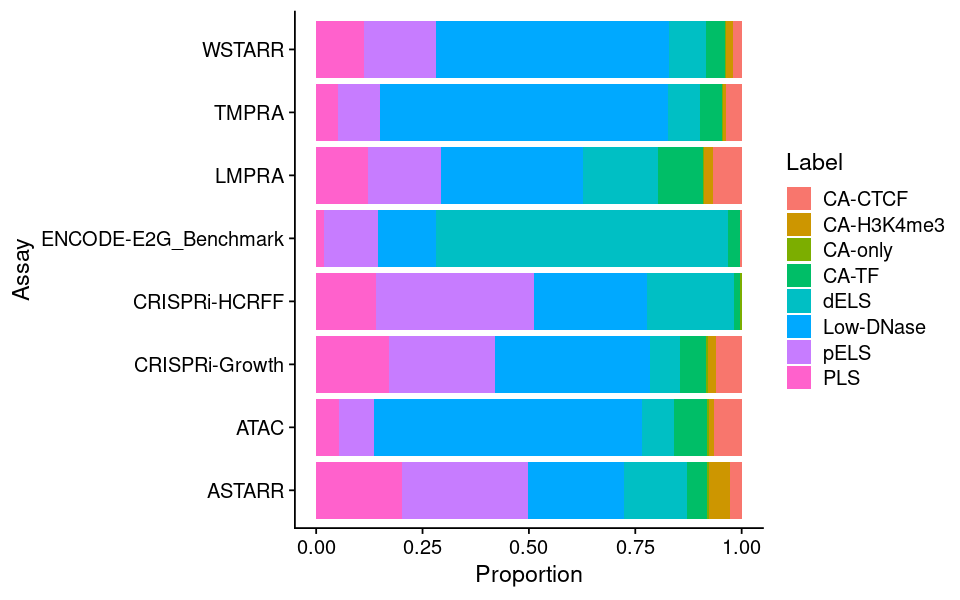

In [11]:
dat = dat_peak_annot_count

gpt = ggplot(dat, aes(x=Assay_Type, y=Freq, fill=Label)) + 
    geom_col() +
    labs(x="Assay", y="Proportion") +
    coord_flip() +
    theme_cowplot()

options(repr.plot.height=5, repr.plot.width=8)
print(gpt)

**Plot with ordering**

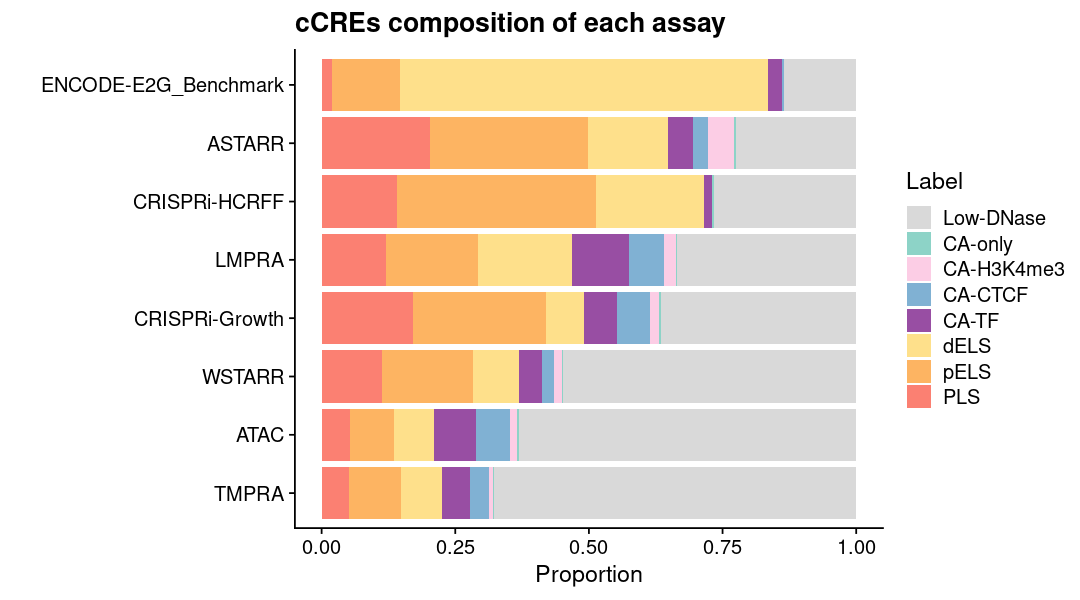

In [15]:
### order Assay
dat = dat_peak_annot_count
dat = dat %>% 
    dplyr::filter(Label == "Low-DNase") %>% 
    dplyr::arrange(Freq)

vec_txt_assay = dat$Assay_Type

### order label
vec_txt_color = c(
    "PLS"        = "#fb8072", 
    "pELS"       = "#fdb462", 
    "dELS"       = "#fee08b", 
    "CA-TF"      = "#984ea3", #"#bebada", 
    "CA-CTCF"    = "#80b1d3", 
    "CA-H3K4me3" = "#fccde5",  
    "CA-only"    = "#8dd3c7", 
    "Low-DNase"  = "#d9d9d9")

vec_txt_label = names(vec_txt_color)

### set factor
dat = dat_peak_annot_count
dat = dat %>% 
    dplyr::mutate(
        Assay_Type = factor(Assay_Type, levels=rev(vec_txt_assay)),
        Label      = factor(Label,      levels=rev(vec_txt_label)),
)

### plot
theme_fill = scale_fill_manual(values = vec_txt_color)

gpt = ggplot(dat, aes(x=Assay_Type, y=Freq, fill=Label)) + 
    geom_col() +
    labs(x="", y="Proportion", title = "cCREs composition of each assay") +
    coord_flip() +
    theme_cowplot() +
    theme_fill

### show and save
options(repr.plot.height=5, repr.plot.width=9)
print(gpt)
ggsave("fig.fcc_table.ccres.proportion.png", gpt, width = 9, height = 4.5)
ggsave("fig.fcc_table.ccres.proportion.pdf", gpt, width = 9, height = 4.5)